In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1127-LSTM-Conv-win120'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(11071, 10671)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([120, 3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([120, 6])

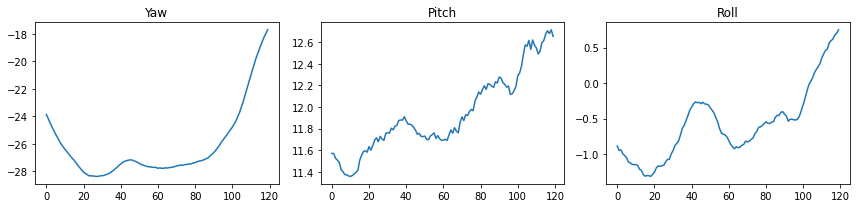

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(x[:, 0])
plt.title('Yaw')

plt.subplot(1, 3, 2)
plt.plot(x[:, 1])
plt.title('Pitch')

plt.subplot(1, 3, 3)
plt.plot(x[:, 2])
plt.title('Roll')

plt.tight_layout()
plt.show()

# 모델 생성

StackedLSTM Bidirectional

In [12]:
class ResBlock1d(nn.Module):
    def __init__(self, inchannels, channels, kernel_size):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(inchannels, channels, 1),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

In [13]:
class M2M_LSTMC(nn.Module):
    def __init__(self):
        super(M2M_LSTMC, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)
        
        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        x = x.transpose(1, 2) # B, 128, S
        x = self.conv_out(x) # B, 3, S
        x = x.transpose(1, 2) # B, S, 3

        return x

In [14]:
model = M2M_LSTMC().cuda()

In [15]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [16]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [17]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [18]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [19]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [20]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 217.0041285923549
                  validation
 - Yaw          :  17.129099
 - Pitch        :  10.163937
 - Roll         :   2.424468
 - RMS          :  12.507289
 - 99% Tile     :  25.949923


[0003/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 217.0041285923549 to 164.56043043590728
                  validation
 - Yaw          :  14.882812
 - Pitch        :   9.312456
 - Roll         :   2.310659
 - RMS          :  11.032274
 - 99% Tile     :  21.143131


[0004/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 164.56043043590728 to 139.85723159426738
                  validation
 - Yaw          :  13.685494
 - Pitch        :   8.568523
 - Roll         :   2.211291
 - RMS          :  10.203502
 - 99% Tile     :  19.722520


[0005/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 139.85723159426738 to 132.04994882856096
                  validation
 - Yaw          :  13.364481
 - Pitch        :   8.074641
 - Roll         :   2.186495
 - RMS          :   9.900288
 - 99% Tile     :  19.509520


[0006/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 132.04994882856096 to 109.60441444033668
                  validation
 - Yaw          :  12.040339
 - Pitch        :   7.305371
 - Roll         :   2.154639
 - RMS          :   8.983205
 - 99% Tile     :  18.192733


[0007/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 109.60441444033668 to 100.53747694832938
                  validation
 - Yaw          :  11.540643
 - Pitch        :   6.924554
 - Roll         :   2.165777
 - RMS          :   8.623657
 - 99% Tile     :  17.281681


[0008/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 100.53747694832938 to 87.06903226034981
                  validation
 - Yaw          :  10.323842
 - Pitch        :   6.644622
 - Roll         :   2.136298
 - RMS          :   7.937274
 - 99% Tile     :  16.748790


[0009/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 87.06903226034981 to 71.52988647279282
                  validation
 - Yaw          :   9.276838
 - Pitch        :   5.708278
 - Roll         :   2.159173
 - RMS          :   7.121433
 - 99% Tile     :  15.437388


[0010/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 71.52988647279282 to 52.71143786112467
                  validation
 - Yaw          :   7.421220
 - Pitch        :   5.215153
 - Roll         :   2.185173
 - RMS          :   6.079014
 - 99% Tile     :  13.509646


[0011/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 52.71143786112467 to 44.08534129460653
                  validation
 - Yaw          :   6.013858
 - Pitch        :   4.557505
 - Roll         :   2.172973
 - RMS          :   5.240098
 - 99% Tile     :  13.675556


[0012/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 44.08534129460653 to 32.577901749383834
                  validation
 - Yaw          :   5.677406
 - Pitch        :   3.650504
 - Roll         :   2.214147
 - RMS          :   4.624869
 - 99% Tile     :  11.563465


[0013/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 32.577901749383834 to 25.243044455846157
                  validation
 - Yaw          :   4.355718
 - Pitch        :   3.086393
 - Roll         :   2.153941
 - RMS          :   3.861335
 - 99% Tile     :  10.564105


[0014/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 25.243044455846157 to 19.110244115193684
                  validation
 - Yaw          :   3.857959
 - Pitch        :   2.503538
 - Roll         :   2.184539
 - RMS          :   3.394345
 - 99% Tile     :   9.133335


[0015/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   4.378193
 - Pitch        :   2.437505
 - Roll         :   2.139484
 - RMS          :   3.564614
 - 99% Tile     :   9.238175


[0016/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 19.110244115193684 to 12.37208092212677
                  validation
 - Yaw          :   2.780198
 - Pitch        :   1.483032
 - Roll         :   2.135964
 - RMS          :   2.580896
 - 99% Tile     :   7.597026


[0017/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 12.37208092212677 to 9.008793757075356
                  validation
 - Yaw          :   2.358292
 - Pitch        :   1.564746
 - Roll         :   1.905256
 - RMS          :   2.241797
 - 99% Tile     :   6.098294


[0018/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 9.008793757075356 to 7.1801468758356
                  validation
 - Yaw          :   2.046054
 - Pitch        :   1.545348
 - Roll         :   1.728644
 - RMS          :   2.005968
 - 99% Tile     :   5.171159


[0019/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.1801468758356 to 6.21053485643296
                  validation
 - Yaw          :   1.839014
 - Pitch        :   1.607383
 - Roll         :   1.545660
 - RMS          :   1.844407
 - 99% Tile     :   4.498686


[0020/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.848142
 - Pitch        :   1.513745
 - Roll         :   1.493230
 - RMS          :   2.268096
 - 99% Tile     :   4.970539


[0021/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.21053485643296 to 4.693559636672339
                  validation
 - Yaw          :   1.573346
 - Pitch        :   0.918991
 - Roll         :   1.411052
 - RMS          :   1.511284
 - 99% Tile     :   4.064707


[0022/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 4.693559636672339 to 4.379127360525585
                  validation
 - Yaw          :   1.554336
 - Pitch        :   0.662774
 - Roll         :   1.249989
 - RMS          :   1.456074
 - 99% Tile     :   4.029481


[0023/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.643000
 - Pitch        :   0.598689
 - Roll         :   0.952254
 - RMS          :   1.781900
 - 99% Tile     :   5.354268


[0024/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.310484
 - Pitch        :   0.815048
 - Roll         :   0.771216
 - RMS          :   1.600211
 - 99% Tile     :   5.156158


[0025/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 4.379127360525585 to 3.339229268687112
                  validation
 - Yaw          :   1.389198
 - Pitch        :   0.865971
 - Roll         :   0.600745
 - RMS          :   1.131580
 - 99% Tile     :   4.085713


[0026/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.339229268687112 to 3.0881890938395546
                  validation
 - Yaw          :   1.427767
 - Pitch        :   0.559630
 - Roll         :   0.669454
 - RMS          :   1.058543
 - 99% Tile     :   3.972274


[0027/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.0881890938395546 to 2.0620019421690987
                  validation
 - Yaw          :   1.060549
 - Pitch        :   0.443141
 - Roll         :   0.419699
 - RMS          :   0.791819
 - 99% Tile     :   2.384850


[0028/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.964483
 - Pitch        :   0.658210
 - Roll         :   0.605029
 - RMS          :   0.881154
 - 99% Tile     :   2.652462


[0029/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.607352
 - Pitch        :   0.620645
 - Roll         :   0.567018
 - RMS          :   1.144135
 - 99% Tile     :   3.674688


[0030/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.101658
 - Pitch        :   0.906423
 - Roll         :   0.519602
 - RMS          :   0.977400
 - 99% Tile     :   2.512117


[0031/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 2.0620019421690987 to 1.719379784095855
                  validation
 - Yaw          :   0.812615
 - Pitch        :   0.463264
 - Roll         :   0.339400
 - RMS          :   0.660901
 - 99% Tile     :   2.348128


[0032/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.719379784095855 to 1.650159311081682
                  validation
 - Yaw          :   0.653971
 - Pitch        :   0.391399
 - Roll         :   0.406921
 - RMS          :   0.570094
 - 99% Tile     :   2.598802


[0033/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.424974
 - Pitch        :   0.498101
 - Roll         :   0.357760
 - RMS          :   0.960999
 - 99% Tile     :   3.940181


[0034/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.088897
 - Pitch        :   0.673497
 - Roll         :   0.347253
 - RMS          :   0.824939
 - 99% Tile     :   3.406596


[0035/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.150125
 - Pitch        :   0.572989
 - Roll         :   0.313302
 - RMS          :   0.841780
 - 99% Tile     :   3.457160


[0036/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.650159311081682 to 1.4454546790747416
                  validation
 - Yaw          :   0.551541
 - Pitch        :   0.452327
 - Roll         :   0.291149
 - RMS          :   0.516665
 - 99% Tile     :   2.298829


[0037/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.792777
 - Pitch        :   0.348649
 - Roll         :   0.304948
 - RMS          :   0.589227
 - 99% Tile     :   2.198017


[0038/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.740904
 - Pitch        :   0.549518
 - Roll         :   0.291887
 - RMS          :   0.621474
 - 99% Tile     :   2.115059


[0039/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.4454546790747416 to 1.4074528359231497
                  validation
 - Yaw          :   0.564357
 - Pitch        :   0.394686
 - Roll         :   0.254173
 - RMS          :   0.478575
 - 99% Tile     :   2.449100


[0040/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.067806
 - Pitch        :   0.501634
 - Roll         :   0.292040
 - RMS          :   0.777873
 - 99% Tile     :   2.252650


[0041/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.885199
 - Pitch        :   0.415222
 - Roll         :   0.271103
 - RMS          :   0.649286
 - 99% Tile     :   2.403349


[0042/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.720120
 - Pitch        :   0.317987
 - Roll         :   0.353746
 - RMS          :   0.555330
 - 99% Tile     :   2.383602


[0043/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.026186
 - Pitch        :   0.367543
 - Roll         :   0.296844
 - RMS          :   0.706545
 - 99% Tile     :   2.239845


[0044/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.865851
 - Pitch        :   0.354086
 - Roll         :   0.265964
 - RMS          :   0.611502
 - 99% Tile     :   3.458481


[0045/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.4074528359231497 to 1.385008494768824
                  validation
 - Yaw          :   0.547840
 - Pitch        :   0.314895
 - Roll         :   0.226260
 - RMS          :   0.440074
 - 99% Tile     :   2.547893


[0046/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.729856
 - Pitch        :   0.332981
 - Roll         :   0.230835
 - RMS          :   0.532733
 - 99% Tile     :   2.392360


[0047/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.600220
 - Pitch        :   0.341698
 - Roll         :   0.255517
 - RMS          :   0.476850
 - 99% Tile     :   2.585864


[0048/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.099831
 - Pitch        :   0.317891
 - Roll         :   0.269191
 - RMS          :   0.723259
 - 99% Tile     :   2.808633


[0049/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.385008494768824 to 1.3141039826330683
                  validation
 - Yaw          :   0.486076
 - Pitch        :   0.334595
 - Roll         :   0.228501
 - RMS          :   0.419245
 - 99% Tile     :   2.294684


[0050/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.545579
 - Pitch        :   0.355889
 - Roll         :   0.237023
 - RMS          :   0.460088
 - 99% Tile     :   2.260257


[0051/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.3141039826330683 to 1.3047754913568497
                  validation
 - Yaw          :   0.499128
 - Pitch        :   0.390680
 - Roll         :   0.233115
 - RMS          :   0.444411
 - 99% Tile     :   2.223239


[0052/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.3047754913568497 to 1.3004340621687112
                  validation
 - Yaw          :   0.524091
 - Pitch        :   0.316552
 - Roll         :   0.241655
 - RMS          :   0.431967
 - 99% Tile     :   2.279879


[0053/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.3004340621687112 to 1.2957542616696585
                  validation
 - Yaw          :   0.417540
 - Pitch        :   0.392693
 - Roll         :   0.244216
 - RMS          :   0.417183
 - 99% Tile     :   2.258023


[0054/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.2957542616696585 to 1.2412514393883092
                  validation
 - Yaw          :   0.420656
 - Pitch        :   0.379056
 - Roll         :   0.226587
 - RMS          :   0.405329
 - 99% Tile     :   2.174832


[0055/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.465532
 - Pitch        :   0.316713
 - Roll         :   0.224226
 - RMS          :   0.400670
 - 99% Tile     :   2.203085


[0056/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.426305
 - Pitch        :   0.404350
 - Roll         :   0.237691
 - RMS          :   0.419897
 - 99% Tile     :   2.189760


[0057/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.480453
 - Pitch        :   0.294000
 - Roll         :   0.234778
 - RMS          :   0.403347
 - 99% Tile     :   2.175649


[0058/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.504328
 - Pitch        :   0.361925
 - Roll         :   0.210805
 - RMS          :   0.430134
 - 99% Tile     :   2.534438


[0059/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.2412514393883092 to 1.2185839865179289
                  validation
 - Yaw          :   0.408167
 - Pitch        :   0.362973
 - Roll         :   0.233727
 - RMS          :   0.394906
 - 99% Tile     :   2.080809


[0060/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.420593
 - Pitch        :   0.306958
 - Roll         :   0.212467
 - RMS          :   0.371185
 - 99% Tile     :   2.178069


[0061/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.431359
 - Pitch        :   0.329296
 - Roll         :   0.210116
 - RMS          :   0.386737
 - 99% Tile     :   2.136028


[0062/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.2185839865179289 to 1.2086137224520956
                  validation
 - Yaw          :   0.482318
 - Pitch        :   0.299528
 - Roll         :   0.228361
 - RMS          :   0.403414
 - 99% Tile     :   2.037294


[0063/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.2086137224520956 to 1.1639464593359403
                  validation
 - Yaw          :   0.406461
 - Pitch        :   0.302994
 - Roll         :   0.217551
 - RMS          :   0.367491
 - 99% Tile     :   1.962331


[0064/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.489078
 - Pitch        :   0.320859
 - Roll         :   0.220958
 - RMS          :   0.415333
 - 99% Tile     :   1.977295


[0065/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.404603
 - Pitch        :   0.293529
 - Roll         :   0.208368
 - RMS          :   0.361009
 - 99% Tile     :   2.044297


[0066/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.483511
 - Pitch        :   0.372867
 - Roll         :   0.213500
 - RMS          :   0.426376
 - 99% Tile     :   2.210237


[0067/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.446006
 - Pitch        :   0.339826
 - Roll         :   0.207345
 - RMS          :   0.393784
 - 99% Tile     :   2.120224


[0068/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.415393
 - Pitch        :   0.344363
 - Roll         :   0.214648
 - RMS          :   0.382603
 - 99% Tile     :   2.160973


[0069/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 1.5625e-05 to 7.8125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.429744
 - Pitch        :   0.286699
 - Roll         :   0.217044
 - RMS          :   0.369678
 - 99% Tile     :   1.914505


[0070/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.588540
 - Pitch        :   0.308226
 - Roll         :   0.215597
 - RMS          :   0.452769
 - 99% Tile     :   2.235542


[0071/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.420649
 - Pitch        :   0.346869
 - Roll         :   0.210986
 - RMS          :   0.386805
 - 99% Tile     :   2.053155


[0072/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 7.8125e-06 to 3.90625e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.485567
 - Pitch        :   0.314102
 - Roll         :   0.210002
 - RMS          :   0.405300
 - 99% Tile     :   2.252704


[0072/0200] Validation: 100%|██████████████████████| 42/42 [00:02<00:00, 14.84it/s, val_loss 1.2326]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.440863
 - Pitch        :   0.356851
 - Roll         :   0.216480
 - RMS          :   0.400308
 - 99% Tile     :   2.159103
